https://mpmath.org/
"nternally, mpmath represents a floating-point number (−1)sx⋅2y by a tuple (s, x, y, b) where x and y are arbitrary-size Python integers and the redundant integer b stores the bit length of x for quick access. If GMPY (Horsen, 2015) is installed, mpmath automatically uses the gmpy.mpz type for x, and GMPY methods for rounding-related operations, improving performance." https://peerj.com/articles/cs-103/



https://www.youtube.com/watch?v=8tCcfR5COHc Automated Error Analysis of Numerical Kernels for High-Consequence Systems with Frama-C pollar. suggesting extensions to acsl
https://sampollard.github.io/research/artifacts/pollard_ldrd24_presentation.pdf

error models
https://pavpanchekha.com/blog/epsilon-delta.html
Eva https://malyzajko.github.io/


https://www.cl.cam.ac.uk/~jrh13/fpv/index.html harrison floating point veification
https://link.springer.com/article/10.1023/A:1008712907154 hrisson float point expoential tang



Mini herbie using z3 egraph
Direct lambdify to numpy

numpy based axiom validation.


https://www.cl.cam.ac.uk/~lp15/papers/Arith/
https://dl.acm.org/doi/10.1145/3543670 formal verificatio nof trsacnednetla float - coward metritarksi
references a list of known bounds 
Marc Daumas, David Lester, and César Munoz. 2008. Verified real number calculations: A library for interval arithmetic. IEEE Trans. Comput. 58, 2 (2008), 226–237. https://arxiv.org/pdf/0708.3721
[17] Marc Daumas and Guillaume Melquiond. 2010. Certification of bounds on expressions involving rounded operators.
ACM Transactions on Mathematical Software (TOMS) 37, 1 (2010), 2.

derive bounds using z3 optimize or a branching procedure. We don't need the _tightest_ bounds.

call gappa from knuckeldragger


How to bootstrap:
We should be fuzzing floats
Quickcheck
Hypothesis?

Calcium - is computing on constants that useful?
python flint taylor series approx.


https://arxiv.org/pdf/2207.00921  Auto-active Verification of Floating-point Programs via Nonlinear Real Provers
https://github.com/rasheedja/PropaFP

dreal

https://pages.saclay.inria.fr/sylvie.boldo/publis.html Sylvie Boldo
Computer Arithmetic and Formal Proofs
Verifying Floating-point Algorithms with the Coq System - book

https://inria.hal.science/hal-01630143v2  Formally Verified Approximations of Definite Integrals

lebesguq induction  https://inria.hal.science/hal-03564379v2

# diy floaty
aka softfloat

ok actually doing it bit accurate is useful

In [ ]:
from fractions import Fraction

def myfloat(mant, exp):
    return Fraction(mant) * 2 ** exp



In [ ]:
C

In [ ]:
class MyFloat():
    mant : int
    exp : int

    def __add__(self, other):

    def rnd()


In [87]:
import kdrag as kd
import kdrag.smt as smt

RFloat32 = kd.Newtype('RFloat32', kd.R)
x = smt.Real("x")
eps32 = Function("eps32", kd.R, kd.R) 
eps32_bnd = kd.axiom(smt.ForAll([x], And(-2**-23 <= eps32(x), eps32(x) <= 2**-23)))
delta32 = Function("delta32", kd.R, kd.R)
delta32_bnd = kd.axiom(smt.ForAll([x], And(-2**-126 <= delta32(x), delta32(x) <= 2**-126)))
x = smt.Real("x")
rnd32 = kd.define("rnd32", [x], RFloat32.mk(x*(1+eps32(x)) + delta32(x)))
x,y = smt.Consts("x y", RFloat32)
kd.notation.add.define([x,y], rnd32(x.val + y.val))




AttributeError: module 'kdrag' has no attribute 'Newtype'

# upper lower




In [94]:
import kdrag as kd
import kdrag.theories.real as real
import kdrag.smt as smt

x,y = smt.Reals("x y")
sqrt_upper_0 = kd.lemma(kd.QForAll([x], x >= 0, real.sqrt(x) <= 0.5*x + 0.5), by=[real.sqrt_square])

c = kd.Calc([x], x, assume=[x >= 0])
c.eq(real.sqrt(x) * real.sqrt(x), by=[real.sqrt_square])
c.le(real.sqrt(x) * (0.5*x + 0.5), by=[sqrt_upper_0, real.sqrt_pos])
_1 = c.qed()
sqrt_lower_0 = kd.lemma(kd.QForAll([x], x >= 0, real.sqrt(x) >= x / (0.5*x + 0.5)), by=[_1])

# alternatively in one shot
sqrt_lower_0 = kd.lemma(kd.QForAll([x], x >= 0, real.sqrt(x) >= x / (0.5*x + 0.5)), by=[real.sqrt_square, real.sqrt_pos])

# This one fails. Our light abtsractions have defeated z3's ability to solve stuff. Hmm. Why.
sqrt_lower_0 = kd.lemma(kd.QForAll([x], x >= 0, real.sqrt(x) >= x / (0.5*x + 0.5)), by=[real.sqrt.defn])


# similarly for higher approximations

#kd.search(kd.sqrt)




LemmaError: ('lemma', ForAll(x, Implies(x >= 0, sqrt(x) >= x/(1/2*x + 1/2))), [|- ForAll(x, sqrt(x) == x**(1/2))], unknown)

In [115]:
c = kd.Calc([x], real.sqrt(x)**2, assume=[x >= 0])
c.eq(x, by=[real.sqrt_square])
a = 1/16
c.le((a*x + 1/4/a) ** 2)

... <= (1/16*x + 4)**2

In [97]:
def approx_sqrt():
    ub = 0.5 * x + 0.5
    lb = 0
    while True:
        lb = x / ub
        yield kd.lemma(kd.QForAll([x], x >= 0, real.sqrt(x) >= lb), by=[real.sqrt_square, real.sqrt_pos])
        ub = (ub + lb) / 2
        yield kd.lemma(kd.QForAll([x], x >= 0, real.sqrt(x) <= ub), by=[real.sqrt_square])

j = approx_sqrt()
for i in range(4):
    print(next(j))

|- ForAll(x, Implies(x >= 0, sqrt(x) >= x/(1/2*x + 1/2)))
|- ForAll(x,
       Implies(x >= 0,
               sqrt(x) <= (1/2*x + 1/2 + x/(1/2*x + 1/2))/2))
|- ForAll(x,
       Implies(x >= 0,
               sqrt(x) >=
               x/((1/2*x + 1/2 + x/(1/2*x + 1/2))/2)))
|- ForAll(x,
       Implies(x >= 0,
               sqrt(x) <=
               ((1/2*x + 1/2 + x/(1/2*x + 1/2))/2 +
                x/((1/2*x + 1/2 + x/(1/2*x + 1/2))/2))/
               2))


In [90]:
smt.prove(smt.Implies(x >= 0, x**(1/2) >= x/(0.5*x + 0.5)))
s = smt.Solver() 
s.add(x >= 0)
s.add(Not(x**(1/2) >= x/(0.5*x + 0.5)))
s.check()
#s.model().eval(x**1/2)

proved


unsat

In [74]:
db = kd.utils.lemma_db()
db

{'__main__': {'sqrt_upper_0': |- ForAll(x, Implies(x >= 0, sqrt(x) <= 1/2*x + 1/2))},
 'kdrag.theories.real': {'add_0': |- ForAll(x, add(x, 0) == x),
  'add_comm': |- ForAll([x, y], add(x, y) == add(y, x)),
  'add_assoc': |- ForAll([x, y, z], add(x, add(y, z)) == add(add(x, y), z)),
  'mul_def': |- ForAll([x, y], mul(x, y) == x*y),
  'mul_zero': |- ForAll(x, mul(x, 0) == 0),
  'mul_1': |- ForAll(x, mul(x, 1) == x),
  'mul_comm': |- ForAll([x, y], mul(x, y) == mul(y, x)),
  'mul_assoc': |- ForAll([x, y, z], mul(x, mul(y, z)) == mul(mul(x, y), z)),
  'mul_distrib': |- ForAll([x, y, z],
         mul(x, add(y, z)) == add(mul(x, y), mul(x, z))),
  'sgn_abs': |- ForAll(x, x == absR(x)*ToReal(sgn(x))),
  'abs_le': |- ForAll([x, y], (absR(x) <= y) == And(-y <= x, x <= y)),
  'abs_idem': |- ForAll(x, absR(absR(x)) == absR(x)),
  'abs_neg': |- ForAll(x, absR(-x) == absR(x)),
  'abs_pos': |- ForAll(x, absR(x) >= 0),
  'abs_add': |- ForAll([x, y], absR(x + y) <= absR(x) + absR(y)),
  'abs_mul': |-

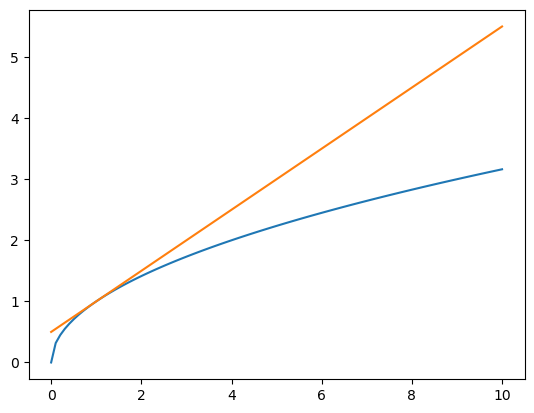

In [118]:
import numpy as np
import matplotlib.pyplot as plt 
xs = np.linspace(0, 10, 100)
ys = np.sqrt(xs)
plt.plot(xs, ys)
plt.plot(xs, 0.5*(xs - 1) + 1)
#plt.plot(xs, xs + 0.25)
#plt.plot(xs, xs / (0.5*xs + 0.5))

In [ ]:
def nitpick(th):
    # assume theorem of form QForAll([x], x >= 0, th)
    # get pieces
    # interpret into something
calcium_map



flint_map = {
    real.sqrt : flint.sqrt,
    real.sqr : flint.sqr,
    real.exp : flint.exp,
    real.ln : flint.ln,
    real.sin : flint.sin,
    real.cos : flint.cos,
    real.tan : flint.tan,
    real.atan : flint.atan,
    real.pow : flint.pow,
    (a + b).decl() : flint.add,
    (a * b).decl() : flint.mul,
    (a / b).decl() : flint.div,
    (a - b).decl() : flint.sub,
    (a ** b).decl() : flint.pow,

}

sympy_map = {
    real.sqrt : sympy.sqrt,
    real.sqr : lambda x: x**2,
    real.exp : sympy.exp,
    real.ln : sympy.ln,
    real.sin : sympy.sin,
    real.cos : sympy.cos,
    real.tan : sympy.tan,
    real.atan : sympy.atan,
    real.pow : sympy.pow,
    (a + b).decl() : sympy.Add,
    (a * b).decl() : sympy.Mul,
    (a / b).decl() : sympy.Div,
    (a - b).decl() : sympy.Sub,
    (a ** b).decl() : sympy.Pow,
}
inv_sympy_map = {v:k for k,v in sympy_map.items()}

np_map = 

dreal_map = {}

cvc5_map = {}

def interp(e, env, decl_map):
    if e in env:
        return env[e]
    
    elif is_app(e):
        decl = e.decl()
        if decl in flint_map:
            return flint_map[decl](*[interp(arg) for arg in e.children()])
    assert False, f"Can't interpret {e}"
    
        



Singularity checking.
It might be a nice debugging thing to have sympy autolist the singularitiyes in an expression.





# dreal

# Fptaylor
https://malyzajko.github.io/papers/sas2023a.pdf
https://codac.io/tutorial/05-tubes/index.html
https://github.com/JuliaIntervals/IntervalOptimisation.jl/blob/master/src/optimise.jl "using the Moore-Skelboe algorithm"
Need rigorous globasl optimizer. dreal?
codac?
arb?

fp fixed point just has d term (subnormal numbers are fixed point)

https://coqinterval.gitlabpages.inria.fr/   forall x, -1 <= x <= 1 ->
  sqrt (1 - x) <= 3/2.

  https://lawrencecpaulson.github.io/2022/05/04/baby-examples.html
  lemma "sqrt 2 + sqrt 3 < sqrt 10"

  lemma
  fixes a::real
  shows "(a*b + b * c + c*a)^3 ≤ (a^2 + a * b + b^2) * (b^2 + b * c + c^2) * (c^2 + c*a + a^2)"
  by sos

In [ ]:
QForAll([x], x <= 2, 1 <= x, Abs(ToReal(ToFP(x)) - x) <= 0.001)

In [ ]:
def rnd(x):
    eps = arb(0, machine_eps)
    d = arb(0, d)
    return x*(1 + eps) + d # but this isn't the _error_

Error, continuity
Reverse error analysis ~ backprop


In [ ]:
#it's kind of dual number ofmrulation
#even a specific x will eventually become non specific upon compositionality.


def rnd(x):
    x,eps = x
    eps = eps + x*interval(fixed)
    return x + eps , eps



In [ ]:
def arb_opt(f, x0, n):
    """ simple interval bisection optimizer"""
    heap = [(f(x0), x0)]
    for i in range(n):
        ys, x0 = heap.pop()
        x0, x1 = x0.bisect()
        heap.append((f(x1), x1))
        heap.append((f(x0), x0))
    return heap.pop()


In [ ]:
import sympy as sp
sp.symbols("x \epsilon \delta")

counter = 0
def rnd(x):
    counter += 1
    eps, d = symbols(f"\epsilon_{counter} \delta_{counter}")
    return eps, d, x*(1 + eps) + d 

def fptaylor_approx(f, x, eps, d):
    R = 
    f.diff(eps) * eps + f.diff(x) * d + R



# taylor models
https://fredrikj.net/python-flint/general.html#power-series
Yea so wait. Can I use flint?

Usually I'd want an exact polynomial + error constant term, but if I get interval coefficients for free, sure.


In [71]:
y = arb_poly()
for i in range(5):
    y = 1 + y.integral()
y
a = arb_poly(y.coeffs()[:4])
b = arb_poly([0]*4 + y.coeffs()[4:])
b

dom = arb(mid=(4,-1),rad=(1,0))
dom
dom = arb(mid=0.5, rad=0.5)
dom.abs_lower()
y(dom)
print(b + a) 
print(y)

a + b(dom)



([0.0416666666666667 +/- 4.26e-17])*x^4 + ([0.166666666666667 +/- 3.71e-16])*x^3 + 0.500000000000000*x^2 + 1.00000000000000*x + 1.00000000000000
([0.0416666666666667 +/- 4.26e-17])*x^4 + ([0.166666666666667 +/- 3.71e-16])*x^3 + 0.500000000000000*x^2 + 1.00000000000000*x + 1.00000000000000


([0.166666666666667 +/- 3.71e-16])*x^3 + 0.500000000000000*x^2 + 1.00000000000000*x + ([1.0 +/- 0.0417])

([2.755732e-6 +/- 8.36e-13])*x^9 + ([2.480159e-5 +/- 9.52e-12])*x^8 + ([0.0001984127 +/- 5.62e-11])*x^7 + ([0.001388889 +/- 4.94e-10])*x^6 + ([0.00833333 +/- 5.63e-9])*x^5 + ([0.0416667 +/- 4.48e-8])*x^4 + ([0.1666667 +/- 7.92e-8])*x^3 + ([0.500000 +/- 1.38e-7])*x^2 + ([1.000000 +/- 2.76e-7])*x + ([1.000000 +/- 2.76e-7])


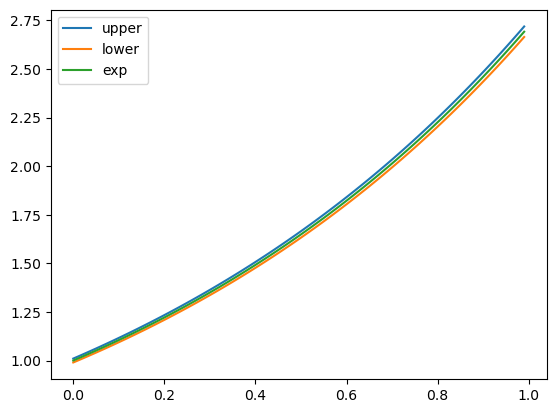

In [85]:
ctx.dps = 100
N = 10
y = arb_poly()
for i in range(30):
    y1 = 1 + y.integral()
    a = arb_poly(y1.coeffs()[:N])
    b = arb_poly([0]*N + y1.coeffs()[N:])
    y = a + b(dom)
    #print(y in y1)
print(y)

from matplotlib import pyplot as plt
import numpy as np
np.linspace(0, 1, 100)
#plt.plot()

def arb_linspace(a,b, n):
    return [arb(mid=(a + i*(b-a)/n), rad=(b-a)/n) for i in range(n)]
xs = arb_linspace(0,1,100)
ys = [y(x) for x in xs]
upper = [y.upper() for y in ys]
lower = [y.lower() for y in ys]
xmid = [x.mid() for x in xs]
plt.plot(xmid, upper, label="upper")
plt.plot(xmid, lower, label="lower")
plt.plot(xmid, [x.exp().mid() for x in xs], label="exp")
plt.legend()

In [14]:
from flint import *
fmpq_series([0,1])

x + O(x^3)

In [2]:
arb_series([1,3,4]).exp()

([2.71828182845905 +/- 5.36e-15]) + ([8.15484548537713 +/- 7.07e-15])*x + ([23.1053955419019 +/- 2.53e-14])*x^2 + ([44.8516501695742 +/- 5.92e-14])*x^3 + ([79.8495287109844 +/- 8.06e-14])*x^4 + ([119.672357497909 +/- 5.21e-13])*x^5 + ([166.302217030267 +/- 4.32e-13])*x^6 + ([208.040787296297 +/- 5.57e-13])*x^7 + ([244.317512266379 +/- 7.50e-13])*x^8 + ([266.364315018834 +/- 7.15e-13])*x^9 + O(x^10)

In [4]:
arb_series([1,1]).exp()

([2.71828182845905 +/- 5.36e-15]) + ([2.71828182845905 +/- 5.36e-15])*x + ([1.35914091422952 +/- 2.78e-15])*x^2 + ([0.453046971409841 +/- 2.27e-16])*x^3 + ([0.113261742852460 +/- 2.31e-16])*x^4 + ([0.0226523485704920 +/- 4.90e-17])*x^5 + ([0.00377539142841534 +/- 1.64e-18])*x^6 + ([0.000539341632630763 +/- 5.32e-19])*x^7 + ([6.74177040788454e-5 +/- 9.15e-20])*x^8 + ([7.4908560087606e-6 +/- 1.13e-20])*x^9 + O(x^10)

In [13]:
ctx.cap = 3
arb_series([1,1,1,1,1]) **2

1.00000000000000 + 2.00000000000000*x + 3.00000000000000*x^2 + O(x^3)

# Why3
Why3 has good aixoms
Just copy them, see where that gets us
fluctuat https://flocq.gitlabpages.inria.fr/
https://coqinterval.gitlabpages.inria.fr/
http://coquelicot.saclay.inria.fr/

https://www.why3.org/stdlib/floating_point.html
https://www.why3.org/stdlib/mach.float.html
https://www.isa-afp.org/entries/IEEE_Floating_Point.html

https://www.philipzucker.com/stupid-is-as-stupid-does-floating-point-in-z3py/

In [3]:
import kdrag as kd
import kdrag.smt as smt
from z3 import *
RNE()

fpAdd
fpMul
fpSub
fpSqrt

fpIsPositive
fpIsZero


<function z3.z3.fpIsZero(a, ctx=None)>

In [15]:
x,y = Consts("x y", FloatDouble())
kd.notation.add.define([x,y], fpAdd(RNE(), x, y))
kd.notation.sub.define([x,y], fpSub(RNE(), x, y))
kd.notation.mul.define([x,y], fpMul(RNE(), x, y))
#kd.notation.sqrt.define([x], fpSqrt(RNE(), x))

prove(x + x == 2*x)
#prove(x + x + x == 3*x)

proved


In [23]:
q = Real("q")
fpRoundToIntegral(RNE(), x)
#fpRealToFP(RNE(), q, FloatDouble())
fpToFP(RNE(), q, FloatDouble())

fpToFP(RNE(), q)

In [28]:
from hypothesis import given
from hypothesis.strategies import text, floats, integers, booleans, composite, one_of, sampled_from

@given(floats(allow_nan=False, allow_infinity=False))
def test_fpAdd(x):
    assert x*x >= 0

test_fpAdd()
#fpSub(fpadd(x,x), fpMul(x,2))


In [35]:
from hypothesis.extra.numpy import arrays
import numpy as np
@given(arrays(dtype=np.float64, shape=(2,),elements=floats(0,1)))
              # elements=floats(allow_nan=False, allow_infinity=False)))
              # overflow detected
def test_array(a):
    assert a[0] + a[1] == a[1] + a[0]
test_array()


def 	get_default_rounding_mode (ctx=None
def 	set_default_rounding_mode (rm, ctx=None)
def 	get_default_fp_sort (ctx=None)
def 	set_default_fp_sort (ebits, sbits, ctx=None)
def 	Float16 (ctx=None)
def 	FloatHalf (ctx=None)
def 	Float32 (ctx=None)
def 	FloatSingle (ctx=None)
def 	Float64 (ctx=None)
def 	FloatDouble (ctx=None)
def 	Float128 (ctx=None)
def 	FloatQuadruple (ctx=None)
def 	is_fp_sort (s)
def 	is_fprm_sort (s)
def 	RoundNearestTiesToEven (ctx=None)
def 	RNE (ctx=None)
def 	RoundNearestTiesToAway (ctx=None)
def 	RNA (ctx=None)
def 	RoundTowardPositive (ctx=None)
def 	RTP (ctx=None)
def 	RoundTowardNegative (ctx=None)
def 	RTN (ctx=None)
def 	RoundTowardZero (ctx=None)
def 	RTZ (ctx=None)
def 	is_fprm (a)
def 	is_fprm_value (a)
def 	is_fp (a)
def 	is_fp_value (a)
def 	FPSort (ebits, sbits, ctx=None)
def 	fpNaN (s)
def 	fpPlusInfinity (s)
def 	fpMinusInfinity (s)
def 	fpInfinity (s, negative)
def 	fpPlusZero (s)
def 	fpMinusZero (s)
def 	fpZero (s, negative)
def 	FPVal (sig, exp=None, fps=None, ctx=None)
def 	FP (name, fpsort, ctx=None)
def 	FPs (names, fpsort, ctx=None)
def 	fpAbs (a, ctx=None)
def 	fpNeg (a, ctx=None)
def 	fpAdd (rm, a, b, ctx=None)
def 	fpSub (rm, a, b, ctx=None)
def 	fpMul (rm, a, b, ctx=None)
def 	fpDiv (rm, a, b, ctx=None)
def 	fpRem (a, b, ctx=None)
def 	fpMin (a, b, ctx=None)
def 	fpMax (a, b, ctx=None)
def 	fpFMA (rm, a, b, c, ctx=None)
def 	fpSqrt (rm, a, ctx=None)
def 	fpRoundToIntegral (rm, a, ctx=None)
def 	fpIsNaN (a, ctx=None)
def 	fpIsInf (a, ctx=None)
def 	fpIsZero (a, ctx=None)
def 	fpIsNormal (a, ctx=None)
def 	fpIsSubnormal (a, ctx=None)
def 	fpIsNegative (a, ctx=None)
def 	fpIsPositive (a, ctx=None)
def 	fpLT (a, b, ctx=None)
def 	fpLEQ (a, b, ctx=None)
def 	fpGT (a, b, ctx=None)
def 	fpGEQ (a, b, ctx=None)
def 	fpEQ (a, b, ctx=None)
def 	fpNEQ (a, b, ctx=None)
def 	fpFP (sgn, exp, sig, ctx=None)
def 	fpToFP (a1, a2=None, a3=None, ctx=None)
def 	fpBVToFP (v, sort, ctx=None)
def 	fpFPToFP (rm, v, sort, ctx=None)
def 	fpRealToFP (rm, v, sort, ctx=None)
def 	fpSignedToFP (rm, v, sort, ctx=None)
def 	fpUnsignedToFP (rm, v, sort, ctx=None)
def 	fpToFPUnsigned (rm, x, s, ctx=None)
def 	fpToSBV (rm, x, s, ctx=None)
def 	fpToUBV (rm, x, s, ctx=None)
def 	fpToReal (x, ctx=None)
def 	fpToIEEEBV (x, ctx=None)

# Fixed Point

https://www.hackster.io/adam-taylor/doing-math-in-fpga-3aa701

https://hardwaredescriptions.com/elementor-fixed-point-arithmetic-in-synthesizable-vhdl/



In [23]:
import knuckledragger as kd
import knuckledragger.theories.Real as R

import numpy as np

#rnd = kd.smt.Function("rnd", kd.R, kd.R, kd.R) #fixed point rounding
#kd.axiom(kd.smt.ForAll([x, y], R.abs(rnd(x, y) - x) <= y)) # This is the important axiom to derive from

def Fixed(eps):
    F = kd.Record(f"Fixed_{eps}", ("val", kd.R ))
    x,y,z = kd.smt.Consts("x y z", F)
    a,b,c = kd.smt.Consts("a b c", kd.R)
    rnd = kd.smt.Function(f"rnd_{eps}", kd.R, F)
    #F.wf = rnd(x).val == x.val # hmm.
    F.rnd = rnd
    # F.rnd = kd.define("rnd", [x], F.mk(R.floor(x / eps) * eps))
    F.rnd_defn = kd.axiom(kd.smt.ForAll([a], R.abs(rnd(a).val - a) <= eps))
    # F.rnd_bnd = kd.axiom(kd.smt.ForAll([x, y], smt.And(eps <= rnd(x).val - x,  rnd(x).val - x.val <= eps))
    # probably not as important
    #F.rnd_idem = kd.axiom(kd.smt.ForAll([x, y], rnd(rnd(x).val).val == x))
    F.add = kd.notation.add.define([x,y], rnd(x.val + y.val))
    kd.notation.mul.define([x,y], rnd(x.val * y.val))
    kd.notation.sub.define([x,y], rnd(x.val - y.val))
    kd.notation.div.define([x,y], rnd(x.val / y.val))
    F.fma = kd.define("fma", [x,y,z], rnd(x.val * y.val + z.val))
    return F
    

F = Fixed(0.1)


a,b,c = kd.smt.Consts("a b c", F)

def mycalc(a,b,c):
    return a + b + c


kd.lemma(mycalc(a,b,c).val - mycalc(a.val, b.val, c.val) <= 0.2, by=[F.rnd_defn, F.add.defn, R.abs.defn])
# How to atudoderive 0.2?
# just use gappa or similar?
# traverse expression to find intermiedtae bounds.
def auto_bnd(x, guess=None):
    bnd = 2**10
    trykd.lemma(x <= bnd,  by=[F.rnd_defn, F.add.defn, R.abs.defn])





|- val(add(add(a, b), c)) - (val(a) + val(b) + val(c)) <= 1/5

In [ ]:

expF = kd.define("expF", [x], kd.exp(x.val))


# JUST work with lagrange remainder form
exp_approx = kd.axiom(exp(x) - (1 + x + x**2 / 2 + x**3 / 3) <= exp(x) * x**4 / 4)

# can I iterate this to arbitrary accuracy?
exp_approx = kd.axiom(exp(x) <= 1 + exp(x) * x) # lagrange form uppper boudn.
exp_lower = kd.axiom(exp(x) >= 1 + x) # lagrange form f' = exp(x) >= 1 is x >= 0. Turns out the always be true via

exp = kd.axiom(exp(x) == 1 + exp(eps) * x), 0 <= eps <= x
exp = kd.axiom(exp(x) == 1 + (1 + exp(eps2) * eps) * x ),  0 <= eps2 <= eps <= x

# we need to find the remainder point. Or have an pproximation scheme to it.
eps ~ (exp(x) - 1 - x) / (x  * exp(eps2)) 

# some kind of guess of eps(x) would help.
exp(x) >= 0
exp(eps) >= 1 # becasue eps >= 0
1 + x + x**2 +  = 1 / 1 - x

# exp(x) <= (1 + x) / (1 + x**2/2)? Huh 

# finite integration
exp(x) = exp(x/2) + exp(eps) (x  - x/2)
exp(x/2) = exp(0) + exp(eps1) (x/2 - 0)
exp(x) = exp(0) + exp(eps1) (x/2) + exp(eps) (x/2) , 0 <= eps1 <= x/2 <= eps <= x

# tube

pow2(x) <= exp(x) <= pow2(x+1) # 2^x <= e^x <= 4^x aka 2 <= e <= 4

And(Implies( box(x,0,1), box(exp(x), 1, )))


# we're asying it obeys an integral eqaution. But we havve to use a fixed point lemma like picard lindelof to show there is value
# we've definied it but we need another principle to bootstrap an actual value.

Implies( QForAll([x], 0 <= x <= 1, b <= exp(x) <= a),  d < exp(x) < c  )  


(i1 -> i2) -> (i2 -> i3)


bisect_f(I) = If( mid(i) <= exp())

def box(l,x,u):
    return And(l <= x, x <= u)

sqrt(x) = sqrt(1) + 

ln(x) = ln(1) + 1 / eps * (x - 1), 1 <= eps <= x

ln(1 - x) = ln(1 - x/2) + 1/ eps * (x/2)
ln(1-x/2) = ln(1) + 1/eps1 * (x/2 - 1)

eps * ln(1-x) = x  # exists 1 <= eps <= x st 
# 1 <= ln() <= x 

ln(1 - x) = 

# https://en.wikipedia.org/wiki/Inverse_function_theorem + mvt
exp(x) = ln^-1(x) = exp(0) + ( 1 / exp(x) ) x # ???


bisect_sqrt(x,a,b) = If((a + b / 2)**2 <= x, bisect_sqrt(x, a, (a + b) / 2), bisect_sqrt(x, (a + b) / 2, b))

# watch out and propagate going out of bounds
def Fixed2(eps, max):
    F = Datatype(f"Fixed_{eps}_{max}")
    F.declare("NaN")
    F.declare("Inf")

https://en.wikipedia.org/wiki/Banach_fixed-point_theorem
Basically, geometric series bound on norm


geom(x,n) = x**n




# FPTalks


https://colab.research.google.com/drive/1bqXS207E4IerbiXSTGKm1KIKAHyjCK50

In [2]:
import numpy as np
def ulp(func=np.float32):
    u = func(1)
    while func(1)+func(u) != func(1):
        u_last = u
        u = func(u) / func(2)
    return u_last
ulp32=ulp(np.float32)
ulp32

1.1920929e-07

eva  - compiler for the reals

nominal completion nd slotted egraphs
f(e2(a), e3(a,b)) -> e1(a,b)

op = 1+e) + d
d for denormla

posits

x*x + y*y

datflow - fatser
daisy
fluctuat

optimzation - optimization
fptaylor
precisa

non modular, no loops
SAS modulao

hugo tool.

<https://github.com/soarlab/FPTaylor>
<https://github.com/malyzajko/daisy>

(Handbook of mathemtical functions)
Kalmand filters

heat equation loop

satire tool and fluctat
<https://github.com/arnabd88/Satire>

<https://github.com/soarlab/gelpia>

conditionals. are still tough

a and b are *atoms*
So we are 3 flat instead of 2 flat

Propel talk diseaqlity forbid. Good chat with him.

https://github.com/metalibm/metalibm

https://gappa.gitlabpages.inria.fr/gappa/index.html

In [2]:
%%file /tmp/testgappa.g
{ x in [-2,2] -> x * x in ? }

Writing /tmp/testgappa.g


In [6]:
! gappa -Blatex /tmp/testgappa.g | pandoc -f latex -t markdown

Results:
  x * x in [0, 4]
Under the following hypotheses $$\label{g1}
\left( \left| \mathit{x} \right| \le2 \land \neg\left( \mathit{x} \times \mathit{x} \in [0,4] \right) \right),$$
one can deduce the following properties: $$\label{l2}
\neg\left( \mathit{x} \times \mathit{x} \in [0,4] \right)$$ by using
([\[g1\]](#g1){reference-type="ref" reference="g1"}), and selecting a
component. $$\label{l5}
\left| \mathit{x} \right| \le2$$ by using
([\[g1\]](#g1){reference-type="ref" reference="g1"}), and selecting a
component. $$\label{l4}
\left| \mathit{x} \right| \le 2$$ by using
([\[l5\]](#l5){reference-type="ref" reference="l5"}), and theorem
`abs_of_bnd_o`. $$\label{l3}
\mathit{x} \times \mathit{x} \in [0,4]$$ by using
([\[l4\]](#l4){reference-type="ref" reference="l4"}), and theorem
`square`. $$\label{l1}
\bot$$ by using ([\[l2\]](#l2){reference-type="ref" reference="l2"}),
([\[l3\]](#l3){reference-type="ref" reference="l3"}), and discarding
contradictory literals.


In [ ]:
import subprocess
def gappa(f):
    


In [ ]:
ex1 = """{ x in [0,1] -> float<ieee_32,ne>(x * float<ieee_32,ne>(1 - x)) in ? }"""
gappa(ex1)
